<a href="https://colab.research.google.com/github/ishitachakravarthy/BGWIT/blob/master/FInetune_audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dependencies

In [ ]:
!pip install pydub

import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np
from scipy.signal import butter,filtfilt
from pydub import AudioSegment
import os
import pydub

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


##Functions

In [ ]:
def analyze_range(sr,sample,low,high):
  Pxx, freqs, bins, im = plt.specgram(sample, Fs=sr)
  samples = Pxx[0].shape[0]
  TimeSeriesWeightedIntensity = [0] * samples
  for i in range(Pxx.shape[0]):
    for time in range(samples):
      if freqs[i]>low and freqs[i]<high:
        TimeSeriesWeightedIntensity[time]+=Pxx[i][time] * (freqs[i])
  return sum(TimeSeriesWeightedIntensity)
  



In [ ]:
def measure_error(arr,cutoff,x):
  human=[]
  speaker=[]
  human+=arr[x[0]:x[1]]
  for i in range(len(x)-1):
    if i%2==0:
      #print(x[i],x[i+1])
      speaker+=(arr[x[i]:x[i+1]])
    else:
      #print('--')
      #print(x[i],x[i+1])
      human+=(arr[x[i]:x[i+1]])
  human_error=0
  speaker_error=0
  for i in human:
    if i<cutoff:
      human_error+=1
  for i in speaker:
    if i>cutoff:
      speaker_error+=1
  print('Human error percentage: '+ str(100*human_error/len(human)))
  print('Speaker error: '+ str(100*speaker_error/len(speaker)))
  print('Total misclassification: '+ str(human_error+speaker_error))
  print('Misclassification percentage: '+ str((human_error+speaker_error)/len(arr)*100))
  print('Total Samples: '+ str(len(arr)))
  return (human_error+speaker_error)/len(arr)*100,100*human_error/len(human),100*speaker_error/len(speaker)

  
  




In [ ]:
def label_data(arr,cutoff):
  res=[]
  for i in arr:
    if i>cutoff:
      res.append(1)
    else:
      res.append(0)
  return res


In [ ]:

def plot_range(name,x,colors,log,low,high,cutoff):
  sr, sample = wavfile.read(f"/content/drive/My Drive/mp3/mono/{name}")
  last=0
  next=sr
  time_segments=[]
  arr=[]
  errors=[]
  for i in range(int(len(sample)/sr-1)):
    if log:
      arr.append(np.log10(analyze_range(sr,sample[last:next],low,high)))
    else:
      arr.append(analyze_range(sr,sample[last:next],low,high))
    last=next
    next+=sr
    time_segments.append(i);
  arr=np.array(arr)
  errors=measure_error(arr,cutoff,x)
  plt.xlabel('Frequency'+ str(low)+' - '+str(high))
  plt.scatter(time_segments,arr,marker='^')
  plt.vlines(x,ymin=0,ymax=max(arr),color=colors)
  plt.hlines(y=cutoff,xmin=0,xmax=len(time_segments))
  plt.ylim(0,sum(arr)/len(arr)+1)
  #plt.ylim(0,120000)
  plt.show()
  labels= label_data(arr,cutoff)
  return labels
      


In [ ]:
def plot_range_for_errors(name,x,colors,log,low,high,cutoff):
  sr, sample = wavfile.read(f"/content/drive/My Drive/mp3/mono/{name}")
  last=0
  next=sr
  time_segments=[]
  arr=[]
  errors=[]
  for i in range(int(len(sample)/sr-1)):
    if log:
      arr.append(np.log10(analyze_range(sr,sample[last:next],low,high)))
    else:
      arr.append(analyze_range(sr,sample[last:next],low,high))
    last=next
    next+=sr
    time_segments.append(i);
  errors=measure_error(arr,cutoff,x)
  plt.xlabel('Frequency'+ str(low)+' - '+str(high))
  plt.scatter(time_segments,arr,marker='^')
  plt.vlines(x,ymin=0,ymax=max(arr),color=colors)
  plt.hlines(y=cutoff,xmin=0,xmax=len(time_segments))
  plt.ylim(0,sum(arr)/len(arr)+1)
  #plt.ylim(0,120000)
  plt.show()
  labels= label_data(arr,cutoff)
  
      


In [ ]:
def get_final_error(res,x):
  x1=[20,46,61,80,95,112,122]
  x2=[22,43,63,84,104,126]
  arr=[]
  arr+=[1]*(x[1]-x[0])
  for i in range(len(x)-1):
    if i%2==0:
      #print(x[i],x[i+1])
      arr+=[0]*(x[i+1]-x[i]+1)
    else:
      arr+=[1]*(x[i+1]-x[i])
      #print('--')
      #print(x[i],x[i+1])
      #human+=(arr[x[i]:x[i+1]])
  print(len(arr))
  err=0
  for i in range(len(res)):
    if arr[i]!=res[i]:
      err+=1
  print('Percentage error: '+ str(err/len(arr)))
  return err/len(arr)



In [ ]:
def estimate_cutoff(name,x,colors,log,low,high):
  cutoff=10
  low=0
  high=100000*100000
  cutoff=(high+low)/2

  while(low<=high):
    print(high,low)
    cutoff=(high+low)/2
    error= plot_range_for_errors(name,x,colors,log,low,high,cutoff)
    if error[0]<25:
      break
    elif error[1]>error[2]:
      high=cutoff-1
    else:
      low=cutoff+1
  
  print(cutoff)
  return cutoff

In [ ]:
def erase_peer(name,res):
  sr, sample = wavfile.read(f"/content/drive/My Drive/mp3/mono/{name}")
  audio=[]
  for i in range(len(res)-1):
    if res[i]==1:
      #print(sample[i*sr:(i+1)*sr])
      audio.append(sample[i*sr:(i+1)*sr])
  audio=np.array(audio)
  #write("example.wav", samplerate, data.astype(np.int16))
  write(f"/content/drive/My Drive/mp3/filtered/{name}.wav", sr, audio)

  



In [ ]:
def fine_tune(name,x,f,k):
  freqs=[10500,11500,12500,13500,14500,15500,16500,17500,18500,19500,20500,21500,22500,23500]
  cutoff=[]
  colors=[]
  labels=[]
  y=[]
  for i in range(len(x)):
    if i%2==0:
      colors.append('red')
    else:
      colors.append('green')
  for i in range(10):
    cutoff.append(pow(10,i))
  #for i in range(len(freqs)):
  #  for j in range(len(freqs)-i-1):
  #    for k in cutoff:
  #      y=plot_range_for_errors(name,x,colors,False,freqs[i],freqs[j+1],cutoff=k)
  #      print(freqs[i],freqs[j+1],k)
  #      ans.append([i,j+1,k,y])
  for i in range(len(freqs)):
    if f>=freqs[i]:
      continue
    plot_range_for_errors(name,x,colors,False,f,freqs[i],cutoff=k)


In [ ]:
def write(f, sr, x, normalized=False):
    """numpy array to MP3"""
    channels = 2 if (x.ndim == 2 and x.shape[1] == 2) else 1
    if normalized:  # normalized array - each item should be a float in [-1, 1)
        y = np.int16(x * 2 ** 15)
    else:
        y = np.int16(x)
    song = pydub.AudioSegment(y.tobytes(), frame_rate=sr, sample_width=2, channels=channels)
    song.export(f, format="mp3", bitrate="320k")

In [ ]:
def get_results_mac(name,x):
  x1=[20,46,61,80,95,112,122]
  x2=[22,43,63,84,104,126]
  bin=[]
  colors=[]
  res=[]
  for i in range(len(x)):
    if i%2==0:
      colors.append('red')
    else:
      colors.append('green')
  bin.append(plot_range(name,x,colors,False,18500,22500,cutoff=2000))
  bin.append(plot_range(name,x,colors,False,11500,13500,cutoff=20000))
  bin.append(plot_range(name,x,colors,False,13500,17500,cutoff=40000))
  bin.append(plot_range(name,x,colors,False,16500,19500,cutoff=5000))
  bin.append(plot_range(name,x,colors,False,17500,19500,cutoff=2000))
  time_segments=[]
  color_dot=[]
  for i in range(len(bin[0])):
    time_segments.append(i)
    print(str(i))
    sum=0
    #for j in range(5):
    #  sum+=bin[j][i]
    sum=bin[0][i]+bin[1][i]+bin[2][i]+bin[3][i]+bin[4][i]
    print(sum)
    if sum>2:
      res.append(1)
      color_dot.append('red')
      print('Human')
    else:
      res.append(0)
      color_dot.append('green')
      print('Speaker')
  predicted=[]
  for i in range(len(res)):
    try:
      if res[i-1]!=res[i] and res[i]==res[i+1] and res[i]==res[i+2] and res[i-1]==res[i-2] and res[i]==res[i+3]:
        predicted.append(i)
    except:
      pass
  plt.scatter(time_segments,res,marker='.',color=color_dot)
  #plt.vlines()
  plt.vlines(x,ymin=0,ymax=1,color=colors)
  #plt.vlines(predicted,ymin=0,ymax=1,linestyle='--')
  plt.ylim(0,1)
  get_final_error(res,x)
  return res


In [ ]:
def get_results_win(name,x):
  bin=[]
  colors=[]
  res=[]
  for i in range(len(x)):
    if i%2==0:
      colors.append('red')
    else:
      colors.append('green')
  bin.append(plot_range(name,x,colors,False,18500,22500,cutoff=125000000))
  bin.append(plot_range(name,x,colors,False,11500,13500,cutoff=10000000))
  bin.append(plot_range(name,x,colors,False,13500,17500,cutoff=30000000))
  bin.append(plot_range(name,x,colors,False,16500,19500,cutoff=50000000))
  bin.append(plot_range(name,x,colors,False,17500,19500,cutoff=35000000))
  time_segments=[]
  color_dot=[]
  for i in range(len(bin[0])):
    time_segments.append(i)
    print(str(i))
    sum=0
    #for j in range(5):
    #  sum+=bin[j][i]
    sum=bin[0][i]+bin[1][i]+bin[2][i]+bin[3][i]+bin[4][i]
    print(sum)
    if sum>2:
      res.append(1)
      color_dot.append('red')
      print('Human')
    else:
      res.append(0)
      color_dot.append('green')
      print('Speaker')
  predicted=[]
  for i in range(len(res)):
    try:
      if res[i-1]!=res[i] and res[i]==res[i+1] and res[i]==res[i+2] and res[i-1]==res[i-2] and res[i]==res[i+3]:
        predicted.append(i)
    except:
      pass
  plt.scatter(time_segments,res,marker='.',color=color_dot)
  #plt.vlines()
  plt.vlines(x,ymin=0,ymax=1,color=colors)
  #plt.vlines(predicted,ymin=0,ymax=1,linestyle='--')
  plt.ylim(0,1)
  get_final_error(res,x)
  return res


##Optimization analysis

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


Human error percentage: 49.18032786885246
Speaker error: 24.193548387096776
Total misclassification: 45
Misclassification percentage: 36.29032258064516
Total Samples: 124


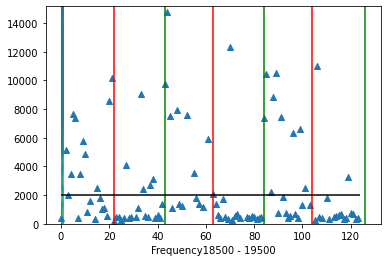

Human error percentage: 39.34426229508197
Speaker error: 30.64516129032258
Total misclassification: 43
Misclassification percentage: 34.67741935483871
Total Samples: 124


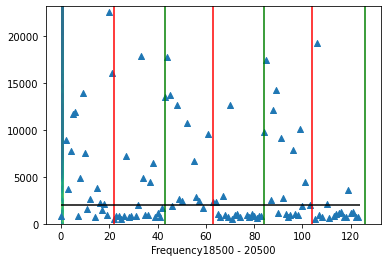

Human error percentage: 34.42622950819672
Speaker error: 30.64516129032258
Total misclassification: 40
Misclassification percentage: 32.25806451612903
Total Samples: 124


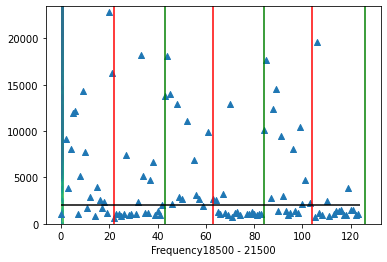

Human error percentage: 31.147540983606557
Speaker error: 32.25806451612903
Total misclassification: 39
Misclassification percentage: 31.451612903225808
Total Samples: 124


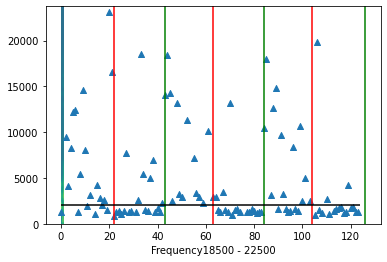

Human error percentage: 24.59016393442623
Speaker error: 40.32258064516129
Total misclassification: 40
Misclassification percentage: 32.25806451612903
Total Samples: 124


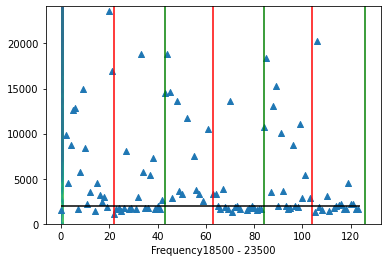

In [ ]:
x=[22,43,63,84,104,126]
fine_tune('single_2',x,18500) # cutoff = 2000

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


Human error percentage: 34.42622950819672
Speaker error: 25.806451612903224
Total misclassification: 37
Misclassification percentage: 29.838709677419356
Total Samples: 124


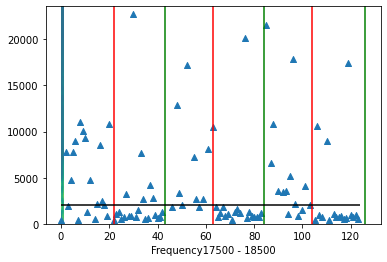

Human error percentage: 24.59016393442623
Speaker error: 33.87096774193548
Total misclassification: 36
Misclassification percentage: 29.03225806451613
Total Samples: 124


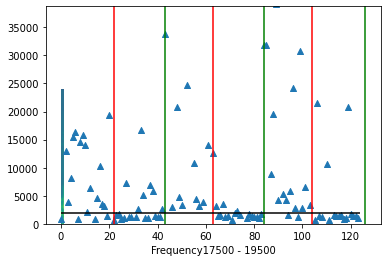

Human error percentage: 22.950819672131146
Speaker error: 45.16129032258065
Total misclassification: 42
Misclassification percentage: 33.87096774193548
Total Samples: 124


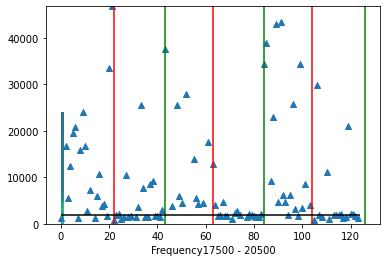

Human error percentage: 19.672131147540984
Speaker error: 59.67741935483871
Total misclassification: 49
Misclassification percentage: 39.516129032258064
Total Samples: 124


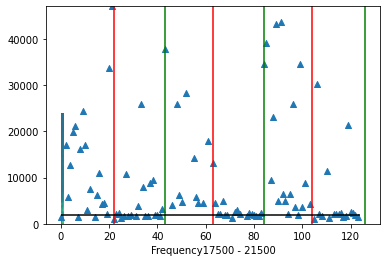

Human error percentage: 4.918032786885246
Speaker error: 80.64516129032258
Total misclassification: 53
Misclassification percentage: 42.74193548387097
Total Samples: 124


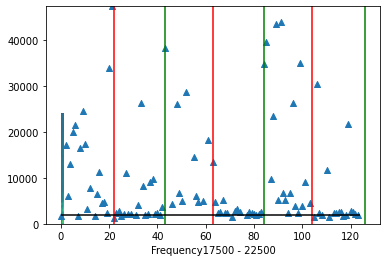

Human error percentage: 3.278688524590164
Speaker error: 91.93548387096774
Total misclassification: 59
Misclassification percentage: 47.58064516129033
Total Samples: 124


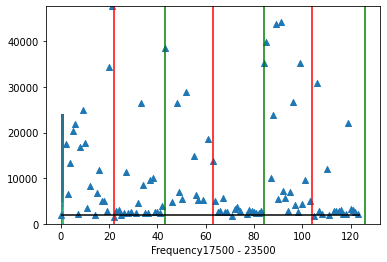

In [ ]:
x=[22,43,63,84,104,126]
fine_tune('single_2',x,17500,2000) # cutoff = 2000
# 17500-19500 - cutoff = 2000 - 30 percent error
# 17500 - 18500

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


Human error percentage: 50.81967213114754
Speaker error: 19.35483870967742
Total misclassification: 43
Misclassification percentage: 34.67741935483871
Total Samples: 124


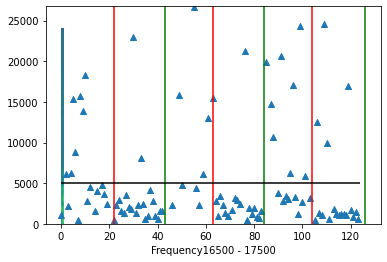

Human error percentage: 32.78688524590164
Speaker error: 25.806451612903224
Total misclassification: 36
Misclassification percentage: 29.03225806451613
Total Samples: 124


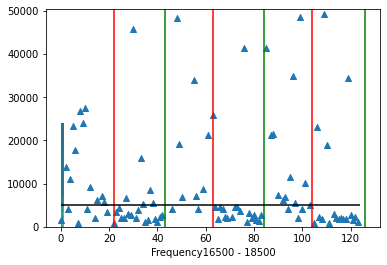

Human error percentage: 27.868852459016395
Speaker error: 32.25806451612903
Total misclassification: 37
Misclassification percentage: 29.838709677419356
Total Samples: 124


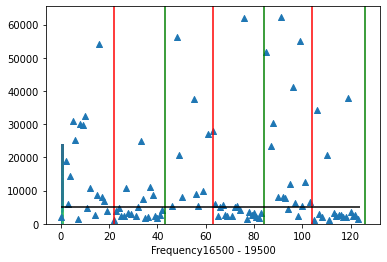

Human error percentage: 24.59016393442623
Speaker error: 37.096774193548384
Total misclassification: 38
Misclassification percentage: 30.64516129032258
Total Samples: 124


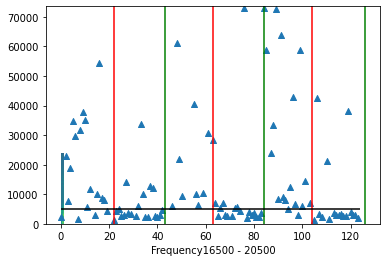

Human error percentage: 22.950819672131146
Speaker error: 37.096774193548384
Total misclassification: 37
Misclassification percentage: 29.838709677419356
Total Samples: 124


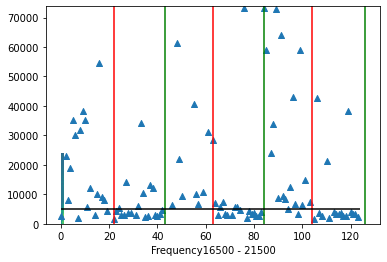

Human error percentage: 21.311475409836067
Speaker error: 38.70967741935484
Total misclassification: 37
Misclassification percentage: 29.838709677419356
Total Samples: 124


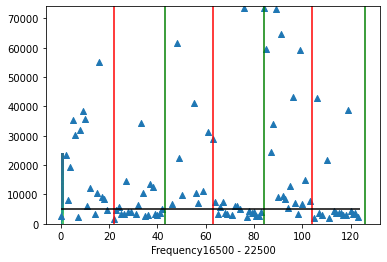

Human error percentage: 19.672131147540984
Speaker error: 41.935483870967744
Total misclassification: 38
Misclassification percentage: 30.64516129032258
Total Samples: 124


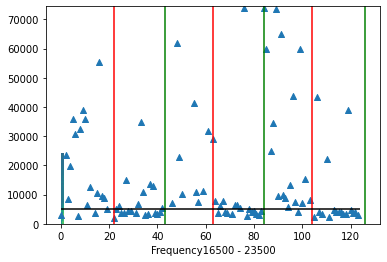

In [ ]:
x=[22,43,63,84,104,126]
fine_tune('single_2',x,16500,5000) 
# 16500-18500 - 5000
#16500- 19500 - 5000


/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


Human error percentage: 57.377049180327866
Speaker error: 19.35483870967742
Total misclassification: 47
Misclassification percentage: 37.903225806451616
Total Samples: 124


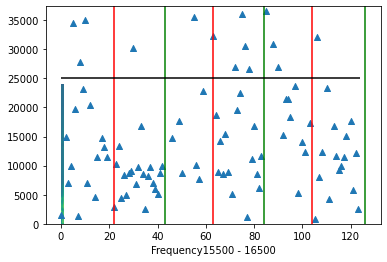

Human error percentage: 44.26229508196721
Speaker error: 25.806451612903224
Total misclassification: 43
Misclassification percentage: 34.67741935483871
Total Samples: 124


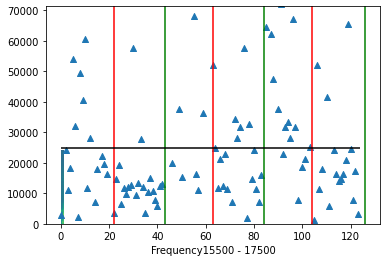

Human error percentage: 40.98360655737705
Speaker error: 32.25806451612903
Total misclassification: 45
Misclassification percentage: 36.29032258064516
Total Samples: 124


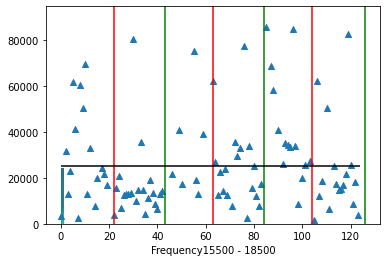

Human error percentage: 40.98360655737705
Speaker error: 32.25806451612903
Total misclassification: 45
Misclassification percentage: 36.29032258064516
Total Samples: 124


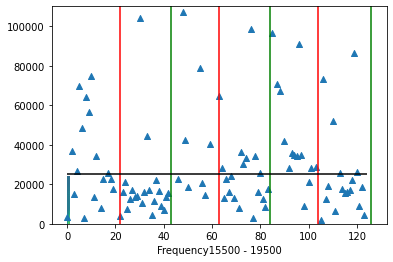

Human error percentage: 40.98360655737705
Speaker error: 32.25806451612903
Total misclassification: 45
Misclassification percentage: 36.29032258064516
Total Samples: 124


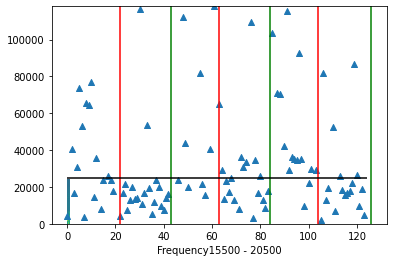

Human error percentage: 40.98360655737705
Speaker error: 32.25806451612903
Total misclassification: 45
Misclassification percentage: 36.29032258064516
Total Samples: 124


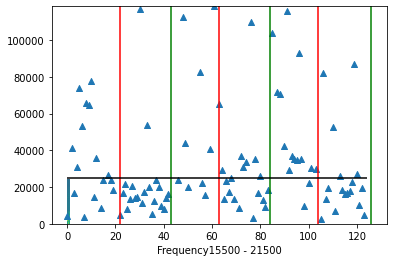

Human error percentage: 40.98360655737705
Speaker error: 33.87096774193548
Total misclassification: 46
Misclassification percentage: 37.096774193548384
Total Samples: 124


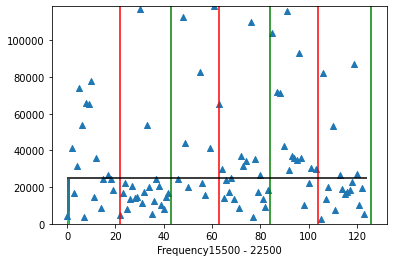

Human error percentage: 40.98360655737705
Speaker error: 33.87096774193548
Total misclassification: 46
Misclassification percentage: 37.096774193548384
Total Samples: 124


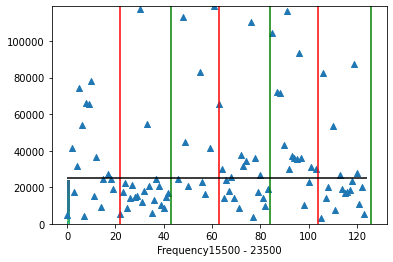

In [ ]:
x=[22,43,63,84,104,126]
fine_tune('single_2',x,15500,25000) 

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


Human error percentage: 65.57377049180327
Speaker error: 6.451612903225806
Total misclassification: 44
Misclassification percentage: 35.483870967741936
Total Samples: 124


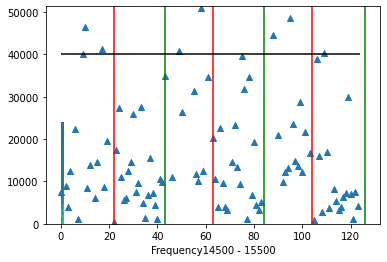

Human error percentage: 50.81967213114754
Speaker error: 24.193548387096776
Total misclassification: 46
Misclassification percentage: 37.096774193548384
Total Samples: 124


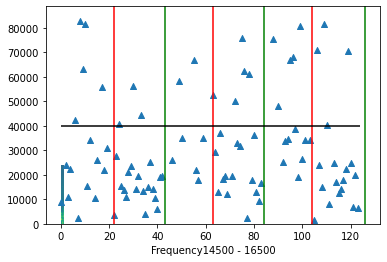

Human error percentage: 39.34426229508197
Speaker error: 30.64516129032258
Total misclassification: 43
Misclassification percentage: 34.67741935483871
Total Samples: 124


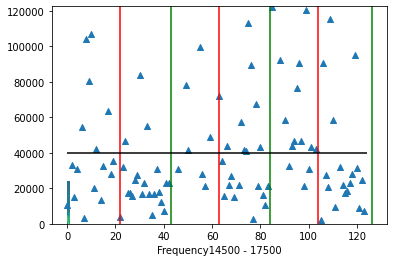

Human error percentage: 39.34426229508197
Speaker error: 30.64516129032258
Total misclassification: 43
Misclassification percentage: 34.67741935483871
Total Samples: 124


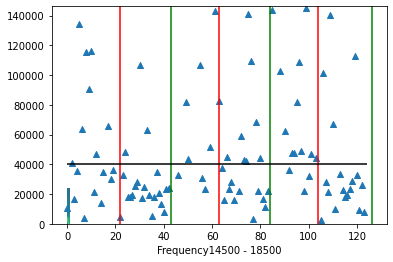

Human error percentage: 39.34426229508197
Speaker error: 30.64516129032258
Total misclassification: 43
Misclassification percentage: 34.67741935483871
Total Samples: 124


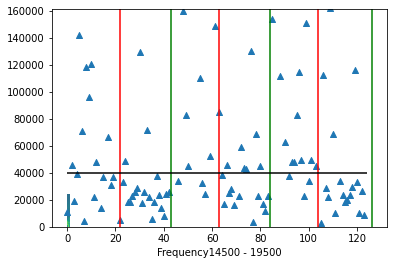

Human error percentage: 39.34426229508197
Speaker error: 30.64516129032258
Total misclassification: 43
Misclassification percentage: 34.67741935483871
Total Samples: 124


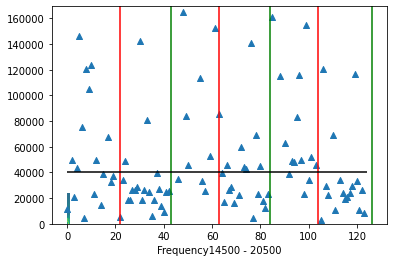

Human error percentage: 39.34426229508197
Speaker error: 30.64516129032258
Total misclassification: 43
Misclassification percentage: 34.67741935483871
Total Samples: 124


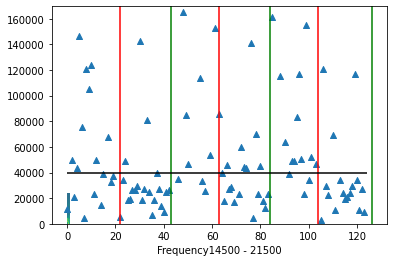

Human error percentage: 39.34426229508197
Speaker error: 32.25806451612903
Total misclassification: 44
Misclassification percentage: 35.483870967741936
Total Samples: 124


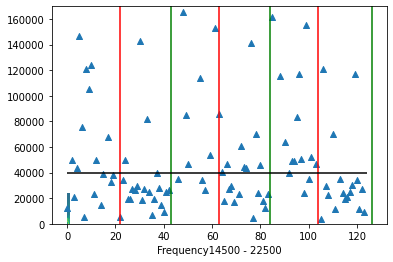

Human error percentage: 37.704918032786885
Speaker error: 33.87096774193548
Total misclassification: 44
Misclassification percentage: 35.483870967741936
Total Samples: 124


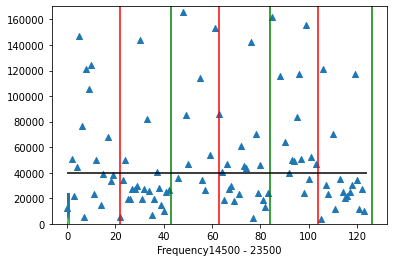

In [ ]:
x=[22,43,63,84,104,126]
fine_tune('single_2',x,14500,40000) 

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


Human error percentage: 75.40983606557377
Speaker error: 4.838709677419355
Total misclassification: 49
Misclassification percentage: 39.516129032258064
Total Samples: 124


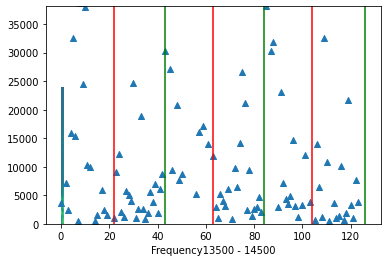

Human error percentage: 55.73770491803279
Speaker error: 17.741935483870968
Total misclassification: 45
Misclassification percentage: 36.29032258064516
Total Samples: 124


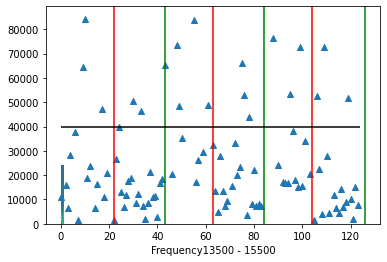

Human error percentage: 44.26229508196721
Speaker error: 27.419354838709676
Total misclassification: 44
Misclassification percentage: 35.483870967741936
Total Samples: 124


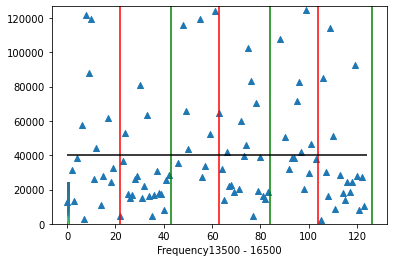

Human error percentage: 36.0655737704918
Speaker error: 32.25806451612903
Total misclassification: 42
Misclassification percentage: 33.87096774193548
Total Samples: 124


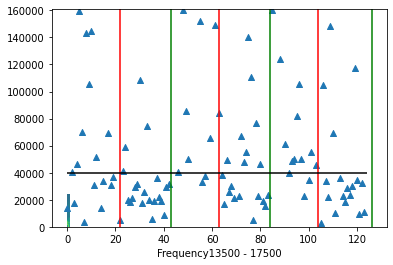

Human error percentage: 32.78688524590164
Speaker error: 35.483870967741936
Total misclassification: 42
Misclassification percentage: 33.87096774193548
Total Samples: 124


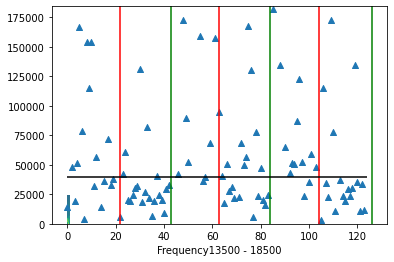

Human error percentage: 31.147540983606557
Speaker error: 35.483870967741936
Total misclassification: 41
Misclassification percentage: 33.064516129032256
Total Samples: 124


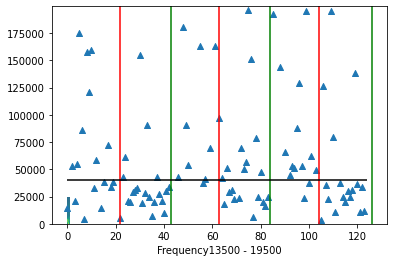

Human error percentage: 31.147540983606557
Speaker error: 35.483870967741936
Total misclassification: 41
Misclassification percentage: 33.064516129032256
Total Samples: 124


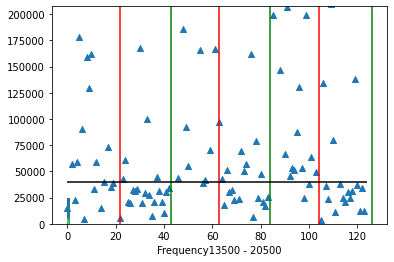

Human error percentage: 31.147540983606557
Speaker error: 35.483870967741936
Total misclassification: 41
Misclassification percentage: 33.064516129032256
Total Samples: 124


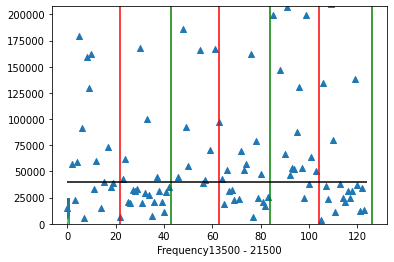

Human error percentage: 31.147540983606557
Speaker error: 35.483870967741936
Total misclassification: 41
Misclassification percentage: 33.064516129032256
Total Samples: 124


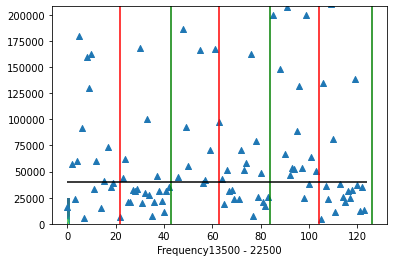

Human error percentage: 31.147540983606557
Speaker error: 35.483870967741936
Total misclassification: 41
Misclassification percentage: 33.064516129032256
Total Samples: 124


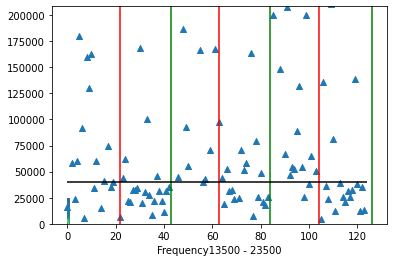

In [ ]:
x=[22,43,63,84,104,126]
fine_tune('single_2',x,13500,40000) 

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


Human error percentage: 65.57377049180327
Speaker error: 9.67741935483871
Total misclassification: 46
Misclassification percentage: 37.096774193548384
Total Samples: 124


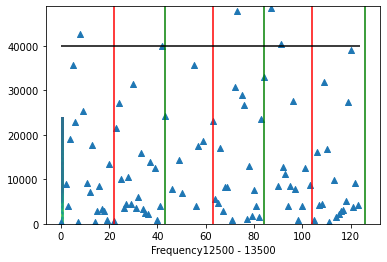

Human error percentage: 52.459016393442624
Speaker error: 24.193548387096776
Total misclassification: 47
Misclassification percentage: 37.903225806451616
Total Samples: 124


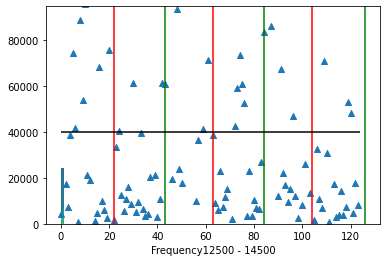

Human error percentage: 40.98360655737705
Speaker error: 35.483870967741936
Total misclassification: 47
Misclassification percentage: 37.903225806451616
Total Samples: 124


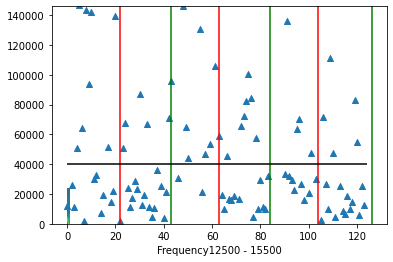

Human error percentage: 27.868852459016395
Speaker error: 41.935483870967744
Total misclassification: 43
Misclassification percentage: 34.67741935483871
Total Samples: 124


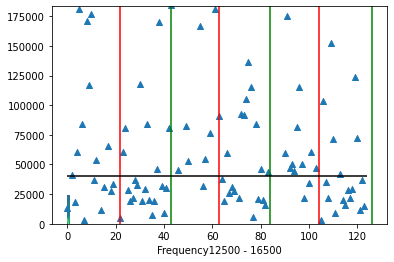

Human error percentage: 26.229508196721312
Speaker error: 46.774193548387096
Total misclassification: 45
Misclassification percentage: 36.29032258064516
Total Samples: 124


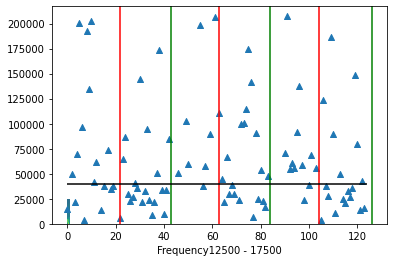

Human error percentage: 22.950819672131146
Speaker error: 46.774193548387096
Total misclassification: 43
Misclassification percentage: 34.67741935483871
Total Samples: 124


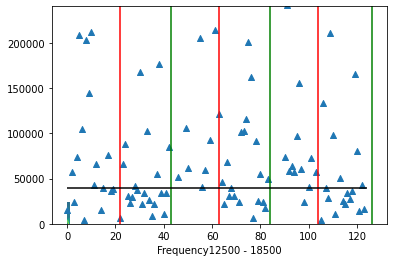

Human error percentage: 22.950819672131146
Speaker error: 46.774193548387096
Total misclassification: 43
Misclassification percentage: 34.67741935483871
Total Samples: 124


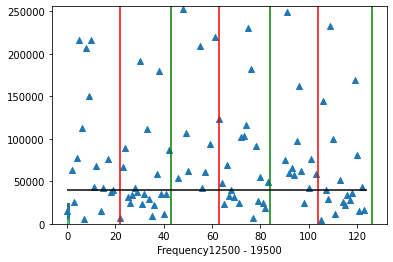

Human error percentage: 22.950819672131146
Speaker error: 50.0
Total misclassification: 45
Misclassification percentage: 36.29032258064516
Total Samples: 124


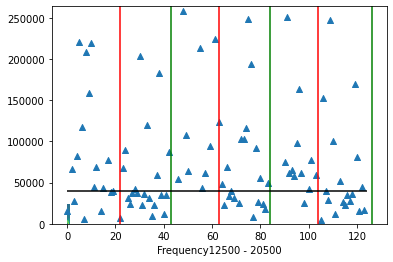

Human error percentage: 22.950819672131146
Speaker error: 50.0
Total misclassification: 45
Misclassification percentage: 36.29032258064516
Total Samples: 124


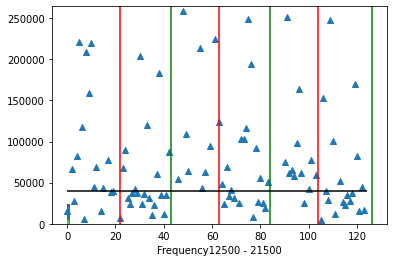

Human error percentage: 22.950819672131146
Speaker error: 50.0
Total misclassification: 45
Misclassification percentage: 36.29032258064516
Total Samples: 124


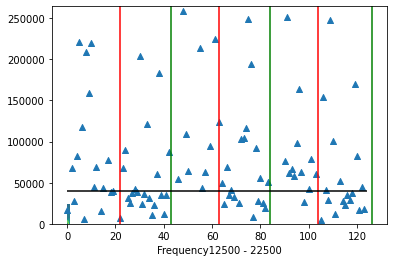

Human error percentage: 22.950819672131146
Speaker error: 50.0
Total misclassification: 45
Misclassification percentage: 36.29032258064516
Total Samples: 124


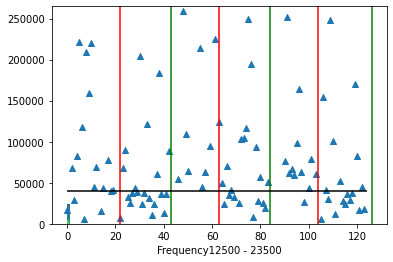

In [ ]:
x=[22,43,63,84,104,126]
fine_tune('single_2',x,12500,40000) 

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


Human error percentage: 52.459016393442624
Speaker error: 22.580645161290324
Total misclassification: 46
Misclassification percentage: 37.096774193548384
Total Samples: 124


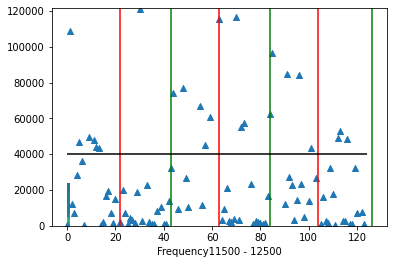

Human error percentage: 45.90163934426229
Speaker error: 33.87096774193548
Total misclassification: 49
Misclassification percentage: 39.516129032258064
Total Samples: 124


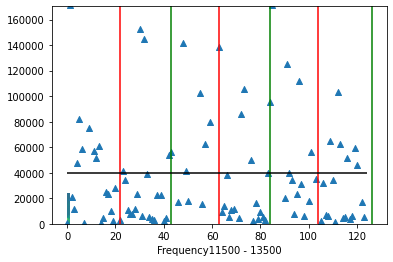

Human error percentage: 40.98360655737705
Speaker error: 41.935483870967744
Total misclassification: 51
Misclassification percentage: 41.12903225806452
Total Samples: 124


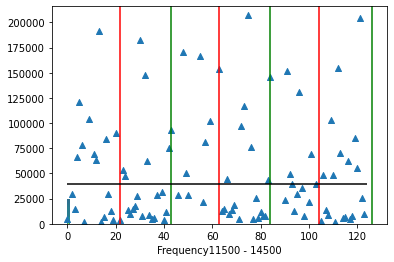

Human error percentage: 26.229508196721312
Speaker error: 46.774193548387096
Total misclassification: 45
Misclassification percentage: 36.29032258064516
Total Samples: 124


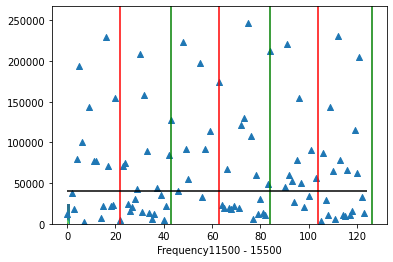

Human error percentage: 19.672131147540984
Speaker error: 53.225806451612904
Total misclassification: 45
Misclassification percentage: 36.29032258064516
Total Samples: 124


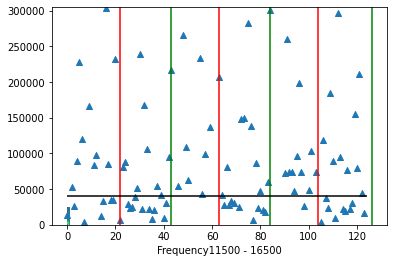

Human error percentage: 18.0327868852459
Speaker error: 58.064516129032256
Total misclassification: 47
Misclassification percentage: 37.903225806451616
Total Samples: 124


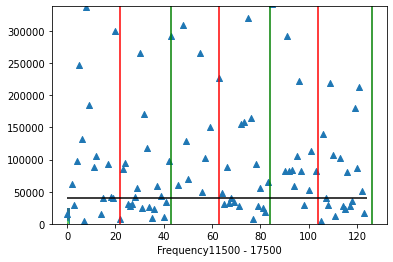

Human error percentage: 18.0327868852459
Speaker error: 58.064516129032256
Total misclassification: 47
Misclassification percentage: 37.903225806451616
Total Samples: 124


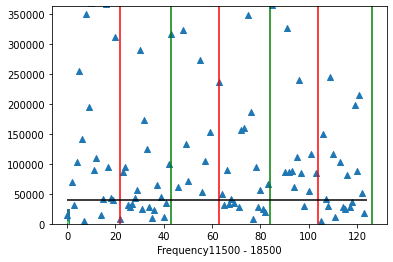

Human error percentage: 18.0327868852459
Speaker error: 58.064516129032256
Total misclassification: 47
Misclassification percentage: 37.903225806451616
Total Samples: 124


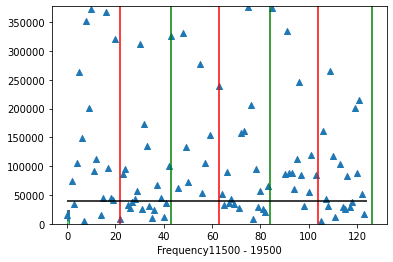

Human error percentage: 16.39344262295082
Speaker error: 59.67741935483871
Total misclassification: 47
Misclassification percentage: 37.903225806451616
Total Samples: 124


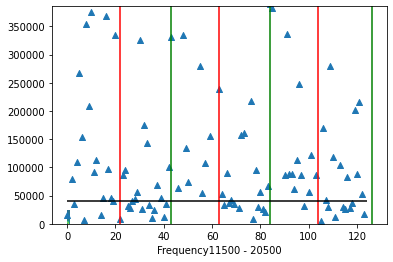

Human error percentage: 16.39344262295082
Speaker error: 59.67741935483871
Total misclassification: 47
Misclassification percentage: 37.903225806451616
Total Samples: 124


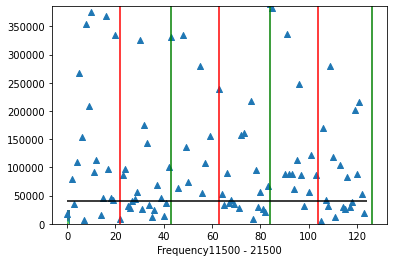

Human error percentage: 16.39344262295082
Speaker error: 59.67741935483871
Total misclassification: 47
Misclassification percentage: 37.903225806451616
Total Samples: 124


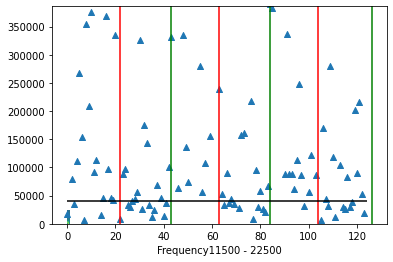

Human error percentage: 16.39344262295082
Speaker error: 59.67741935483871
Total misclassification: 47
Misclassification percentage: 37.903225806451616
Total Samples: 124


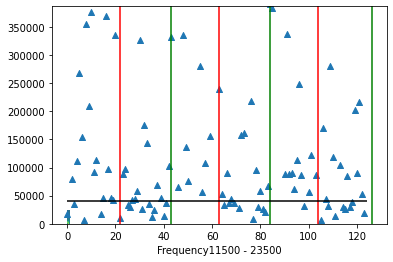

In [ ]:
x=[22,43,63,84,104,126]
fine_tune('single_2',x,11500,40000) 

##Classifier

###Mac-Mac

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


Human error percentage: 31.147540983606557
Speaker error: 32.25806451612903
Total misclassification: 39
Misclassification percentage: 31.451612903225808
Total Samples: 124
Human error percentage: 27.868852459016395
Speaker error: 46.774193548387096
Total misclassification: 46
Misclassification percentage: 37.096774193548384
Total Samples: 124
Human error percentage: 36.0655737704918
Speaker error: 32.25806451612903
Total misclassification: 42
Misclassification percentage: 33.87096774193548
Total Samples: 124
Human error percentage: 27.868852459016395
Speaker error: 32.25806451612903
Total misclassification: 37
Misclassification percentage: 29.838709677419356
Total Samples: 124
Human error percentage: 24.59016393442623
Speaker error: 33.87096774193548
Total misclassification: 36
Misclassification percentage: 29.03225806451613
Total Samples: 124
0
0
Speaker
1
5
Human
2
5
Human
3
3
Human
4
5
Human
5
5
Human
6
5
Human
7
0
Speaker
8
5
Human
9
5
Human
10
5
Human
11
2
Speaker
12
5
Human
13
5


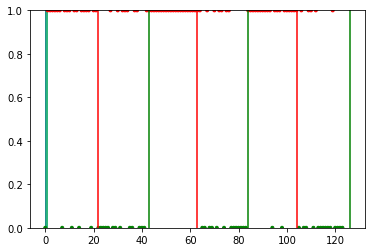

In [ ]:
x2=[22,43,63,84,104,126]
res=get_results_mac('single_2',x2)

In [ ]:
erase_peer('single_2',res)

###Win-Win

Human error percentage: 59.32203389830509
Speaker error: 1.694915254237288
Total misclassification: 36
Misclassification percentage: 30.252100840336134
Total Samples: 119
Human error percentage: 49.152542372881356
Speaker error: 1.694915254237288
Total misclassification: 30
Misclassification percentage: 25.210084033613445
Total Samples: 119
Human error percentage: 59.32203389830509
Speaker error: 1.694915254237288
Total misclassification: 36
Misclassification percentage: 30.252100840336134
Total Samples: 119
Human error percentage: 69.49152542372882
Speaker error: 1.694915254237288
Total misclassification: 42
Misclassification percentage: 35.294117647058826
Total Samples: 119
Human error percentage: 67.79661016949153
Speaker error: 0.0
Total misclassification: 40
Misclassification percentage: 33.61344537815126
Total Samples: 119
0
1
Speaker
1
5
Human
2
0
Speaker
3
5
Human
4
4
Human
5
5
Human
6
0
Speaker
7
3
Human
8
0
Speaker
9
5
Human
10
5
Human
11
5
Human
12
5
Human
13
1
Speaker
14
5


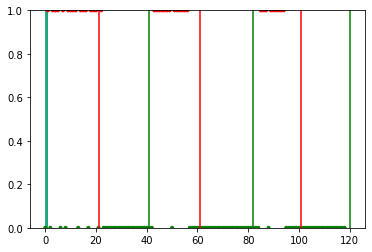

In [ ]:
t1=[21,41,61,82,101,120]
res=get_results_win('win-win-teams-2',t1)
erase_peer('win-win-teams-2',res)

In [ ]:
def queue_result_win(name,x):
  bin=[]
  colors=[]
  res=[]
  for i in range(len(x)):
    if i%2==0:
      colors.append('red')
    else:
      colors.append('green')
  bin.append(plot_range(name,x,colors,False,18500,22500,cutoff=125000000))
  bin.append(plot_range(name,x,colors,False,11500,13500,cutoff=10000000))
  bin.append(plot_range(name,x,colors,False,13500,17500,cutoff=30000000))
  bin.append(plot_range(name,x,colors,False,16500,19500,cutoff=50000000))
  bin.append(plot_range(name,x,colors,False,17500,19500,cutoff=35000000))
  time_segments=[]
  color_dot=[]
  for i in range(len(bin[0])):
    time_segments.append(i)
    print(str(i))
    sum=0
    #for j in range(5):
    #  sum+=bin[j][i]
    sum=bin[0][i]+bin[1][i]+bin[2][i]+bin[3][i]+bin[4][i]
    #print(sum)
    if sum>2:
      res.append(1)
      color_dot.append('red')
      print('Human')
    else:
      res.append(0)
      color_dot.append('green')
      print('Speaker')
  predicted=[]
  for i in range(len(res)):
    try:
      sum=res[i-1]+res[i-2]+res[i]+res[i+1]+res[i+2]
      if sum>2:
        res[i]=1
      else:
        res[i]=0
      if res[i-1]!=res[i] and res[i]==res[i+1] and res[i]==res[i+2] and res[i-1]==res[i-2] and res[i]==res[i+3]:
        predicted.append(i)
    except Exception as err:
      print(err)
  plt.scatter(time_segments,res,marker='.',color=color_dot)
  #plt.vlines()
  plt.vlines(x,ymin=0,ymax=1,color=colors)
  #plt.vlines(predicted,ymin=0,ymax=1,linestyle='--')
  plt.ylim(0,1)
  get_final_error(res,x)
  return res


Human error percentage: 59.32203389830509
Speaker error: 1.694915254237288
Total misclassification: 36
Misclassification percentage: 30.252100840336134
Total Samples: 119
Human error percentage: 49.152542372881356
Speaker error: 1.694915254237288
Total misclassification: 30
Misclassification percentage: 25.210084033613445
Total Samples: 119
Human error percentage: 59.32203389830509
Speaker error: 1.694915254237288
Total misclassification: 36
Misclassification percentage: 30.252100840336134
Total Samples: 119
Human error percentage: 69.49152542372882
Speaker error: 1.694915254237288
Total misclassification: 42
Misclassification percentage: 35.294117647058826
Total Samples: 119
Human error percentage: 67.79661016949153
Speaker error: 0.0
Total misclassification: 40
Misclassification percentage: 33.61344537815126
Total Samples: 119
0
Speaker
1
Human
2
Speaker
3
Human
4
Human
5
Human
6
Speaker
7
Human
8
Speaker
9
Human
10
Human
11
Human
12
Human
13
Speaker
14
Human
15
Human
16
Human
17
Spe

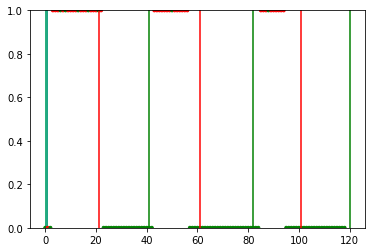

In [ ]:
t1=[21,41,61,82,101,120]
#res1=get_results_win('win-win-teams-1',t1)
res2=queue_result_win('win-win-teams-2',t1)
erase_peer('win-win-teams-2',res2)

In [ ]:
def queue_result_win(name,x):
  bin=[]
  colors=[]
  res=[]
  for i in range(len(x)):
    if i%2==0:
      colors.append('red')
    else:
      colors.append('green')
  bin.append(plot_range(name,x,colors,False,18500,22500,cutoff=20000000))
  bin.append(plot_range(name,x,colors,False,11500,13500,cutoff=2000000))
  bin.append(plot_range(name,x,colors,False,13500,17500,cutoff=5000000))
  bin.append(plot_range(name,x,colors,False,16500,19500,cutoff=8000000))
  bin.append(plot_range(name,x,colors,False,17500,19500,cutoff=6000000))
  time_segments=[]
  color_dot=[]
  for i in range(len(bin[0])):
    time_segments.append(i)
    print(str(i))
    sum=0
    #for j in range(5):
    #  sum+=bin[j][i]
    sum=bin[0][i]+bin[1][i]+bin[2][i]+bin[3][i]+bin[4][i]
    #print(sum)
    if sum>2:
      res.append(1)
      color_dot.append('red')
      print('Human')
    else:
      res.append(0)
      color_dot.append('green')
      print('Speaker')
  predicted=[]
  for i in range(len(res)):
    try:
      sum=res[i-1]+res[i-2]+res[i]+res[i+1]+res[i+2]
      if sum>2:
        res[i]=1
      else:
        res[i]=0
      if res[i-1]!=res[i] and res[i]==res[i+1] and res[i]==res[i+2] and res[i-1]==res[i-2] and res[i]==res[i+3]:
        predicted.append(i)
    except Exception as err:
      print(err)
  plt.scatter(time_segments,res,marker='.',color=color_dot)
  #plt.vlines()
  plt.vlines(x,ymin=0,ymax=1,color=colors)
  #plt.vlines(predicted,ymin=0,ymax=1,linestyle='--')
  plt.ylim(0,1)
  get_final_error(res,x)
  return res


/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


Human error percentage: 33.333333333333336
Speaker error: 25.0
Total misclassification: 35
Misclassification percentage: 29.166666666666668
Total Samples: 120


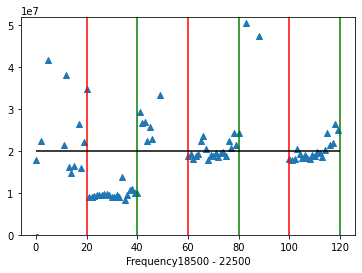

Human error percentage: 33.333333333333336
Speaker error: 30.0
Total misclassification: 38
Misclassification percentage: 31.666666666666664
Total Samples: 120


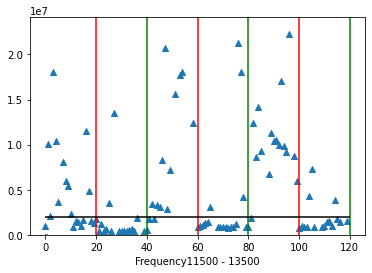

Human error percentage: 41.666666666666664
Speaker error: 6.666666666666667
Total misclassification: 29
Misclassification percentage: 24.166666666666668
Total Samples: 120


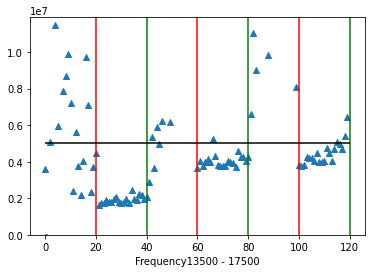

Human error percentage: 41.666666666666664
Speaker error: 6.666666666666667
Total misclassification: 29
Misclassification percentage: 24.166666666666668
Total Samples: 120


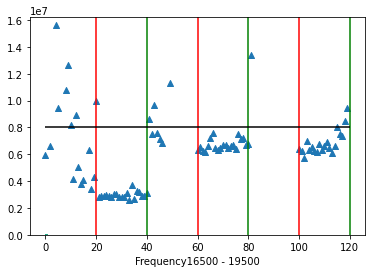

Human error percentage: 40.0
Speaker error: 6.666666666666667
Total misclassification: 28
Misclassification percentage: 23.333333333333332
Total Samples: 120


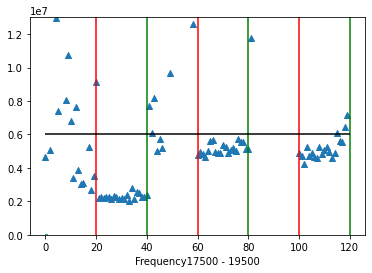

0
Speaker
1
Human
2
Human
3
Human
4
Human
5
Human
6
Human
7
Human
8
Human
9
Human
10
Human
11
Speaker
12
Human
13
Speaker
14
Speaker
15
Speaker
16
Human
17
Human
18
Speaker
19
Speaker
20
Human
21
Speaker
22
Speaker
23
Speaker
24
Speaker
25
Speaker
26
Speaker
27
Speaker
28
Speaker
29
Speaker
30
Speaker
31
Speaker
32
Speaker
33
Speaker
34
Speaker
35
Speaker
36
Speaker
37
Speaker
38
Speaker
39
Speaker
40
Speaker
41
Human
42
Human
43
Human
44
Human
45
Speaker
46
Human
47
Human
48
Human
49
Human
50
Human
51
Human
52
Human
53
Human
54
Human
55
Human
56
Human
57
Human
58
Human
59
Human
60
Speaker
61
Speaker
62
Speaker
63
Speaker
64
Speaker
65
Speaker
66
Human
67
Speaker
68
Speaker
69
Speaker
70
Speaker
71
Speaker
72
Speaker
73
Speaker
74
Speaker
75
Speaker
76
Speaker
77
Speaker
78
Speaker
79
Speaker
80
Speaker
81
Human
82
Human
83
Human
84
Human
85
Human
86
Human
87
Human
88
Human
89
Human
90
Human
91
Human
92
Human
93
Human
94
Human
95
Human
96
Human
97
Human
98
Human
99
Human
100
Speaker
10

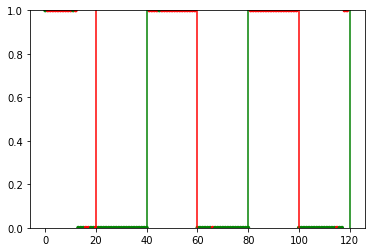

In [ ]:
t1=[20,40,60,80,100,120]
#res1=get_results_win('win-win-teams-1',t1)
res2=queue_result_win('win-win-zoom-1',t1)
erase_peer('win-win-zoom-1',res2)

## Relative cutoffs

In [ ]:
def normalize_data(arr):
  arr=np.array(arr)
  mean=arr.mean()
  max=arr.max()
  min=arr.min()
  std=arr.std()
  arr = [(i-min)*100/(max-min) for i in arr]
  return arr

In [ ]:

def plot_range(name,x,colors,log,low,high,cutoff):
  sr, sample = wavfile.read(f"/content/drive/My Drive/mp3/mono/{name}")
  last=0
  next=sr
  time_segments=[]
  arr=[]
  errors=[]
  for i in range(int(len(sample)/sr-1)):
    if log:
      arr.append(np.log10(analyze_range(sr,sample[last:next],low,high)))
    else:
      arr.append(analyze_range(sr,sample[last:next],low,high))
    last=next
    next+=sr
    time_segments.append(i);
  intensity=np.array(arr)
  c=intensity.mean()
  arr= normalize_data(arr)
  #print(cutoff)
  errors=measure_error(arr,cutoff,x)
  plt.xlabel('Frequency'+ str(low)+' - '+str(high))
  plt.scatter(time_segments,arr,marker='^')
  plt.vlines(x,ymin=min(arr),ymax=max(arr),color=colors)
  plt.hlines(y=cutoff,xmin=0,xmax=len(time_segments))
  plt.ylim(min(arr),10)
  #plt.ylim(0,120000)
  plt.show()
  labels= label_data(arr,cutoff)
  return labels
      


In [ ]:
def queue_result_win(name,x):
  bin=[]
  colors=[]
  res=[]
  for i in range(len(x)):
    if i%2==0:
      colors.append('red')
    else:
      colors.append('green')
  #bin.append(plot_range(name,x,colors,False,18500,22500,cutoff=0.015))
  bin.append(plot_range(name,x,colors,False,11500,13500,cutoff=0.15))
  #bin.append(plot_range(name,x,colors,False,13500,17500,cutoff=0.015))
  #bin.append(plot_range(name,x,colors,False,16500,19500,cutoff=0.015))
  #bin.append(plot_range(name,x,colors,False,17500,19500,cutoff=0.015))
  time_segments=[]
  color_dot=[]
  for i in range(len(bin[0])):
    time_segments.append(i)
    print(str(i))
    sum=0
    #for j in range(5):
    #  sum+=bin[j][i]
    sum=bin[0][i]#+bin[1][i]+bin[2][i]+bin[3][i]+bin[4][i]
    #print(sum)
    if sum==1:
      res.append(1)
      color_dot.append('red')
      print('Human')
    else:
      res.append(0)
      color_dot.append('green')
      print('Speaker')
  predicted=[]
  for i in range(len(res)):
    try:
      sum=res[i-1]+res[i-2]+res[i]+res[i+1]+res[i+2]
      if sum>2:
        res[i]=1
      else:
        res[i]=0
      if res[i-1]!=res[i] and res[i]==res[i+1] and res[i]==res[i+2] and res[i-1]==res[i-2] and res[i]==res[i+3]:
        predicted.append(i)
    except Exception as err:
      print(err)
  plt.scatter(time_segments,res,marker='.',color=color_dot)
  #plt.vlines()
  plt.vlines(x,ymin=0,ymax=1,color=colors)
  #plt.vlines(predicted,ymin=0,ymax=1,linestyle='--')
  plt.ylim(0,1)
  get_final_error(res,x)
  return res


Human error percentage: 28.333333333333332
Speaker error: 15.517241379310345
Total misclassification: 26
Misclassification percentage: 21.84873949579832
Total Samples: 119


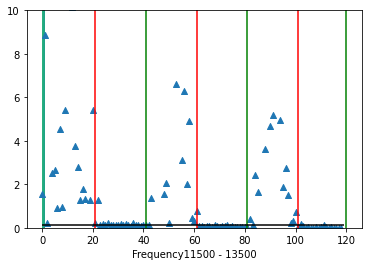

0
Human
1
Human
2
Human
3
Human
4
Human
5
Human
6
Human
7
Human
8
Human
9
Human
10
Human
11
Human
12
Human
13
Human
14
Human
15
Human
16
Human
17
Human
18
Human
19
Human
20
Human
21
Human
22
Human
23
Speaker
24
Human
25
Speaker
26
Human
27
Speaker
28
Speaker
29
Speaker
30
Speaker
31
Human
32
Speaker
33
Human
34
Speaker
35
Speaker
36
Human
37
Speaker
38
Speaker
39
Speaker
40
Speaker
41
Speaker
42
Speaker
43
Human
44
Human
45
Human
46
Human
47
Human
48
Human
49
Human
50
Human
51
Human
52
Human
53
Human
54
Human
55
Human
56
Human
57
Human
58
Human
59
Human
60
Human
61
Human
62
Speaker
63
Speaker
64
Speaker
65
Speaker
66
Speaker
67
Speaker
68
Speaker
69
Speaker
70
Speaker
71
Speaker
72
Speaker
73
Speaker
74
Speaker
75
Speaker
76
Speaker
77
Speaker
78
Speaker
79
Speaker
80
Speaker
81
Speaker
82
Human
83
Speaker
84
Human
85
Human
86
Human
87
Human
88
Human
89
Human
90
Human
91
Human
92
Human
93
Human
94
Human
95
Human
96
Human
97
Human
98
Human
99
Human
100
Human
101
Speaker
102
Human
103
Sp

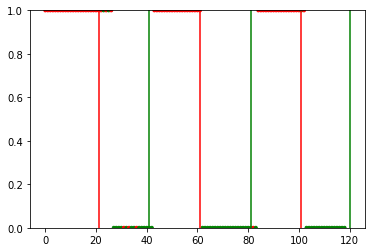

In [ ]:
t1=[21,41,61,81,101,120]
#res1=get_results_win('win-win-teams-1',t1)
res2=queue_result_win('win-win-teams-2',t1)
#erase_peer('single_2',res2)

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


Human error percentage: 1.6666666666666667
Speaker error: 98.30508474576271
Total misclassification: 59
Misclassification percentage: 49.166666666666664
Total Samples: 120


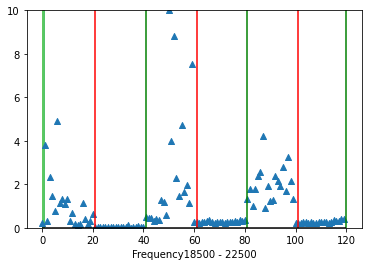

Human error percentage: 25.0
Speaker error: 64.40677966101696
Total misclassification: 53
Misclassification percentage: 44.166666666666664
Total Samples: 120


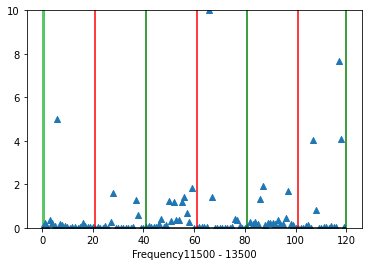

Human error percentage: 10.0
Speaker error: 89.83050847457628
Total misclassification: 59
Misclassification percentage: 49.166666666666664
Total Samples: 120


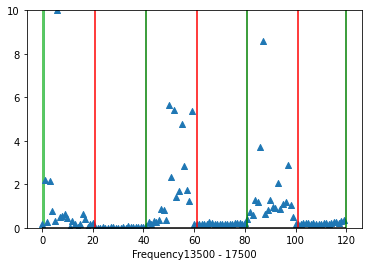

Human error percentage: 3.3333333333333335
Speaker error: 96.61016949152543
Total misclassification: 59
Misclassification percentage: 49.166666666666664
Total Samples: 120


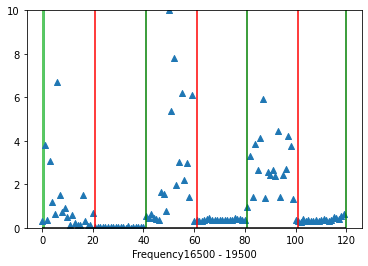

Human error percentage: 1.6666666666666667
Speaker error: 98.30508474576271
Total misclassification: 59
Misclassification percentage: 49.166666666666664
Total Samples: 120


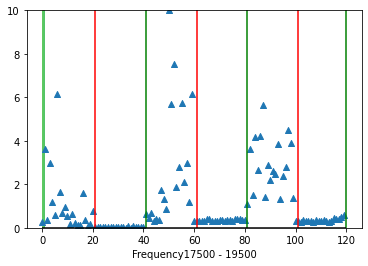

0
Human
1
Human
2
Human
3
Human
4
Human
5
Human
6
Human
7
Human
8
Human
9
Human
10
Human
11
Human
12
Human
13
Human
14
Human
15
Human
16
Human
17
Human
18
Human
19
Human
20
Human
21
Human
22
Human
23
Human
24
Human
25
Human
26
Human
27
Human
28
Human
29
Human
30
Human
31
Human
32
Human
33
Speaker
34
Human
35
Speaker
36
Human
37
Human
38
Human
39
Human
40
Human
41
Human
42
Human
43
Human
44
Human
45
Human
46
Human
47
Human
48
Human
49
Human
50
Human
51
Human
52
Human
53
Human
54
Human
55
Human
56
Human
57
Human
58
Human
59
Human
60
Human
61
Human
62
Human
63
Human
64
Human
65
Human
66
Human
67
Human
68
Human
69
Human
70
Human
71
Human
72
Human
73
Human
74
Human
75
Human
76
Human
77
Human
78
Human
79
Human
80
Human
81
Human
82
Human
83
Human
84
Human
85
Human
86
Human
87
Human
88
Human
89
Human
90
Human
91
Human
92
Human
93
Human
94
Human
95
Human
96
Human
97
Human
98
Human
99
Human
100
Human
101
Human
102
Human
103
Human
104
Human
105
Human
106
Human
107
Human
108
Human
109
Human
110
Hu

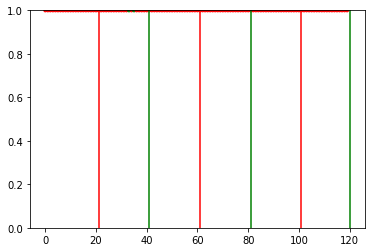

In [ ]:
t1=[21,41,61,81,101,120]
#res1=get_results_win('win-win-teams-1',t1)
res2=queue_result_win('win-win-zoom-1',t1)
#erase_peer('single_2',res2)

In [ ]:
 def all_data(name,x): 
  bin=[]
  colors=[]
  res=[]
  for i in range(len(x)):
    if i%2==0:
      colors.append('red')
    else:
      colors.append('green')
  bin.append(plot_range(name,x,colors,False,11500,13500,cutoff=0.15))

Human error percentage: 36.666666666666664
Speaker error: 5.084745762711864
Total misclassification: 25
Misclassification percentage: 20.833333333333336
Total Samples: 120


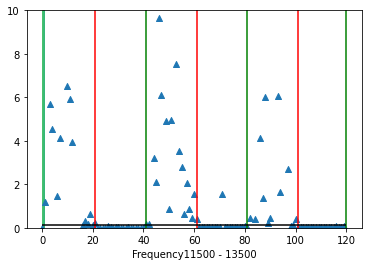

In [ ]:
t1=[21,41,61,81,101,120]
all_data('win-win-teams-1',t1)

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


Human error percentage: 25.0
Speaker error: 47.45762711864407
Total misclassification: 43
Misclassification percentage: 35.833333333333336
Total Samples: 120


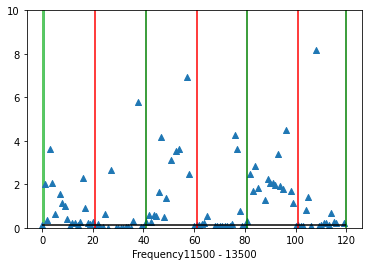

In [ ]:
all_data('win-win-zoom-1',t1)

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


Human error percentage: 16.666666666666668
Speaker error: 71.1864406779661
Total misclassification: 52
Misclassification percentage: 41.935483870967744
Total Samples: 124


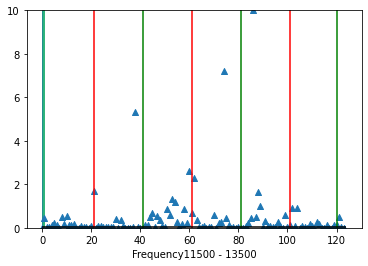

In [ ]:
all_data('single_2',t1)